# Setting Workspace

In [ ]:
# !pip install ipython-autotime
# !pip install transformers

In [ ]:
%load_ext autotime

time: 0 ns (started: 2021-08-15 22:16:37 +02:00)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

time: 0 ns (started: 2021-08-15 22:16:38 +02:00)


In [ ]:
# import os
# os.chdir('/content/drive/My Drive/HLT/')
# !pwd

time: 0 ns (started: 2021-08-15 22:16:38 +02:00)


# Import Libraries

In [ ]:
import json
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import Dropout
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.layers import LSTM, Dense,Flatten,Conv2D,Conv1D,GlobalMaxPooling1D,GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,r2_score,recall_score,confusion_matrix,precision_recall_curve
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

time: 3.72 s (started: 2021-08-15 22:16:39 +02:00)


In [ ]:
pd.set_option('display.max_colwidth', -1) #show all text in col
pd.set_option('display.max_rows', None) #show all rows

time: 0 ns (started: 2021-08-15 22:16:42 +02:00)


C:\Users\luca9\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


# Support Functions


In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

time: 0 ns (started: 2021-08-15 22:16:42 +02:00)


# Load the Dataset

In [ ]:
train_df = pd.read_csv("datasets/train.csv") 
train_df['headline']=train_df['headline'].apply(str)
train_df.head()

,headline,is_sarcastic
0,bill de blasio thinks proved haters wrong comes pre k,0
1,baby realize white supremacist yet,1
2,spring sprung arctic way early,0
3,mayor daley son appointed head illinois nepotist party,1
4,poll grandsons talented,1


time: 31 ms (started: 2021-08-15 22:16:43 +02:00)


In [ ]:
test_df = pd.read_csv("datasets/test.csv") 
test_df['headline']=test_df['headline'].apply(str)
test_df.head()

,headline,is_sarcastic
0,jessie james decker shares inspiring message post baby bodies,0
1,frustrated russian officials struggling get policies dysfunctional trump administration,1
2,second saturday staten island art walk,0
3,chris christie emits loud sob paul ryan asks crowd whether worse years ago,1
4,chicago police department monitor interactions public using new bullet cams,1


time: 15 ms (started: 2021-08-15 22:16:43 +02:00)


In [ ]:
print("Train size:{}".format(train_df.shape))
print("Test size:{}".format(test_df.shape))

Train size:(22702, 2)
Test size:(4007, 2)
time: 0 ns (started: 2021-08-15 22:16:43 +02:00)


## Splitting the set



In [ ]:
train_y = train_df['is_sarcastic']
test_y = test_df['is_sarcastic']

train_x = train_df['headline']
test_x = test_df['headline']
train_x.shape,train_y.shape,test_x.shape,test_y.shape

((22702,), (22702,), (4007,), (4007,))

time: 0 ns (started: 2021-08-15 22:16:43 +02:00)


## Glove


In [ ]:
txt_best_grids = "grid_results/cnn/best_results_cnn_embedding_v1.txt" # name of the txt file with all best results of all runned grid searches
grid_results_name = 'grid_results/cnn/grid_results_cnn_embedding_v1.csv' # name of the csv file with all tests of the current grid search

time: 0 ns (started: 2021-08-15 22:16:43 +02:00)


In [ ]:
# Build Static Embedding on top of a CNN

maxlen=26
max_features=200 
embed_size=300
 

#Tokenizing steps- must be remembered
tokenizer=Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_x))

train_x=tokenizer.texts_to_sequences(train_x)
test_x=tokenizer.texts_to_sequences(test_x)

#Pad the sequence- To allow same length for all vectorized words
train_x=pad_sequences(train_x,maxlen=maxlen)
test_x=pad_sequences(test_x,maxlen=maxlen)

print("Padded and Tokenized Training Sequence".format(),train_x.shape)
print("Target Values Shape".format(),train_y.shape)
print("Padded and Tokenized Testing Sequence".format(),test_y.shape)
print("Target Values Shape".format(),test_y.shape)

Padded and Tokenized Training Sequence (22702, 26)
Target Values Shape (22702,)
Padded and Tokenized Testing Sequence (4007,)
Target Values Shape (4007,)
time: 547 ms (started: 2021-08-15 22:16:43 +02:00)


In [ ]:
# Function to create model, required for KerasClassifier
def create_model(neurons_layer_1=60,
                 activation='relu',
                 neurons_layer_2 = 16,
                 dropout_1 = 0.5, dropout_2 = 0.2,
                 neurons_layer_3 = 20, learn_rate = 0.1, kernel_size = 3,
                 neurons_layer_4 = 10, dropout_3 = 0.1):
  # create model
    model = Sequential()
    model.add(Embedding(max_features,embed_size,input_length=maxlen))
    model.add(Conv1D(neurons_layer_1,activation='relu', kernel_size= kernel_size))
    model.add(GlobalMaxPool1D())

    model.add(Dense(neurons_layer_2, activation='relu'))
    model.add(Dropout(dropout_1))

    model.add(Dense(neurons_layer_3, activation="relu"))
    model.add(Dropout(dropout_2))

    model.add(Dense(neurons_layer_4, activation="relu"))
    model.add(Dropout(dropout_3))

    model.add(Dense(1,activation='sigmoid'))
    # Compile model
    optimizer = Adam(learning_rate=learn_rate)
    # Compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
    return model

BATCH_SIZE = train_x.shape[0]

# create model
nn = KerasClassifier(build_fn=create_model, verbose=2) #verbose = 0
# define the grid search parameters
batch_size = [128, 256]
epochs = [20]
learn_rate = [0.0001, 0.001, 0.01]
# momentum = [0.0]#, 0.2, 0.4, 0.9]
# nesterov = [False]
neurons_layer_1 = [256]
neurons_layer_2 = [128]
neurons_layer_3 = [64]
dropout_1 = [0.5]
dropout_2 = [0.5, 0.3]
# init_mode = ['glorot_uniform']
activation = ['relu']#, 'tanh', 'sigmoid']
# weight_decay = [0.1]#, 0.01, 0.001, 0.0001]
kernel_size = [5, 3, maxlen]
neurons_layer_4 = [32]
dropout_3 = [0.3, 0.1]

param_grid = dict(batch_size=batch_size, epochs=epochs, neurons_layer_1=neurons_layer_1, 
                  activation=activation, neurons_layer_2=neurons_layer_2, neurons_layer_3 = neurons_layer_3,
                  dropout_1 = dropout_1, dropout_2 = dropout_2, learn_rate=learn_rate,
                  kernel_size = kernel_size, neurons_layer_4 = neurons_layer_4, dropout_3 = dropout_3)

grid = GridSearchCV(estimator=nn, param_grid=param_grid, n_jobs=6, cv=StratifiedKFold(3), return_train_score=True, verbose=True)
grid_result = grid.fit(train_x, train_y)


opt_df = grid_result.best_estimator_
print("{}".format(grid_result.best_params_))
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = test_y, grid.predict(test_x)
print(classification_report(y_true, y_pred))
print()


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Epoch 1/20
89/89 - 5s - loss: 0.6858 - accuracy: 0.5573
Epoch 2/20
89/89 - 4s - loss: 0.6707 - accuracy: 0.5822
Epoch 3/20
89/89 - 5s - loss: 0.6422 - accuracy: 0.6409
Epoch 4/20
89/89 - 5s - loss: 0.6087 - accuracy: 0.6734
Epoch 5/20
89/89 - 5s - loss: 0.5917 - accuracy: 0.6847
Epoch 6/20
89/89 - 5s - loss: 0.5842 - accuracy: 0.6898
Epoch 7/20
89/89 - 5s - loss: 0.5816 - accuracy: 0.6921
Epoch 8/20
89/89 - 5s - loss: 0.5752 - accuracy: 0.6965
Epoch 9/20
89/89 - 5s - loss: 0.5708 - accuracy: 0.6974
Epoch 10/20
89/89 - 5s - loss: 0.5690 - accuracy: 0.7002
Epoch 11/20
89/89 - 5s - loss: 0.5630 - accuracy: 0.7032
Epoch 12/20
89/89 - 5s - loss: 0.5600 - accuracy: 0.7033
Epoch 13/20
89/89 - 5s - loss: 0.5579 - accuracy: 0.7054
Epoch 14/20
89/89 - 5s - loss: 0.5532 - accuracy: 0.7110
Epoch 15/20
89/89 - 5s - loss: 0.5505 - accuracy: 0.7132
Epoch 16/20
89/89 - 5s - loss: 0.5459 - accuracy: 0.7138
Epoch 17/20
89/89 - 5s - loss: 0.54

C:\Users\luca9\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


16/16 - 0s
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      2248
           1       0.68      0.52      0.59      1759

    accuracy                           0.68      4007
   macro avg       0.68      0.67      0.67      4007
weighted avg       0.68      0.68      0.68      4007


time: 8h 59min 59s (started: 2021-08-15 22:16:44 +02:00)


In [ ]:
# txt file with all best results of all runned grid searches


grid_results_name_str = f'Results wrt: {grid_results_name} \n'
grid_params_str = f'Grid on: {json.dumps(grid_result.param_grid)} \n' 
grid_results_str = f'Best: {grid_result.best_score_} using {grid_result.best_params_} \n'

with open(txt_best_grids, "a") as file_object:
    file_object.write(grid_results_name_str)
    file_object.write(grid_params_str)
    file_object.write(grid_results_str)
    file_object.write('\n')

time: 0 ns (started: 2021-08-16 07:16:44 +02:00)


In [ ]:
print(grid_results_str)

Best: 0.6812615791956583 using {'activation': 'relu', 'batch_size': 256, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dropout_3': 0.3, 'epochs': 20, 'kernel_size': 3, 'learn_rate': 0.0001, 'neurons_layer_1': 256, 'neurons_layer_2': 128, 'neurons_layer_3': 64, 'neurons_layer_4': 32} 

time: 0 ns (started: 2021-08-16 07:16:44 +02:00)


In [ ]:
# grid.cv_results_

time: 0 ns (started: 2021-08-16 07:16:44 +02:00)


In [ ]:
# csv file with all tests of the current grid search

df = pd.DataFrame(grid.cv_results_)[['rank_test_score','mean_test_score',
                                     'std_test_score','mean_train_score',
                                     'std_train_score','param_activation',
                                     'param_batch_size','param_epochs',
                                     'param_neurons_layer_1', 'param_neurons_layer_2',
                                     'param_neurons_layer_3', 'param_dropout_1',
                                     'param_dropout_2', 'param_learn_rate',
                                     'param_dropout_3', 'param_neurons_layer_4',
                                     'param_kernel_size',
                                     'mean_fit_time']].sort_values(by='rank_test_score')

df.rename(columns={'param_activation': 'activation',
                   'param_batch_size': 'batch_size',
                   'param_epochs': 'epochs',
                   'param_neurons_layer_1': 'neurons_layer_1',
                   'param_neurons_layer_2': 'neurons_layer_2',
                   'param_neurons_layer_3': 'neurons_layer_3',
                   'param_neurons_layer_4': 'neurons_layer_4',
                   'param_dropout_1': 'dropout_1',
                   'param_dropout_2': 'dropout_2',
                   'param_dropout_3': 'dropout_3',
                   'param_kernel_size': 'kernel_size',
                   'param_learn_rate':'learning_rate',
                   'mean_test_score': 'mean_val_score',
                   'std_test_score': 'std_val_score',                
                   'rank_test_score': 'rank_val_score'}, inplace=True)

df.mean_train_score *= -1
df.mean_val_score *= -1
df

,rank_val_score,mean_val_score,std_val_score,mean_train_score,std_train_score,activation,batch_size,epochs,neurons_layer_1,neurons_layer_2,neurons_layer_3,dropout_1,dropout_2,learning_rate,dropout_3,neurons_layer_4,kernel_size,mean_fit_time
39,1,-0.681262,0.002016,-0.730685,0.002591,relu,256,20,256,128,64,0.5,0.5,0.0001,0.3,32,3,169.190609
48,2,-0.680381,0.000839,-0.735442,0.003104,relu,256,20,256,128,64,0.5,0.5,0.0001,0.1,32,3,172.122864
54,3,-0.679764,0.001800,-0.733636,0.002470,relu,256,20,256,128,64,0.5,0.3,0.0001,0.3,32,5,258.866716
57,4,-0.679279,0.001887,-0.741300,0.002112,relu,256,20,256,128,64,0.5,0.3,0.0001,0.3,32,3,168.521870
66,5,-0.678751,0.001155,-0.740221,0.001961,relu,256,20,256,128,64,0.5,0.3,0.0001,0.1,32,3,172.481213
42,6,-0.678531,0.001476,-0.704850,0.001972,relu,256,20,256,128,64,0.5,0.5,0.0001,0.3,32,26,1823.616794
51,7,-0.678266,0.003660,-0.705577,0.003463,relu,256,20,256,128,64,0.5,0.5,0.0001,0.1,32,26,1800.179543
63,8,-0.677870,0.002801,-0.732006,0.001362,relu,256,20,256,128,64,0.5,0.3,0.0001,0.1,32,5,272.223618
69,9,-0.677826,0.000551,-0.706039,0.001493,relu,256,20,256,128,64,0.5,0.3,0.0001,0.1,32,26,1801.909652
45,10,-0.677473,0.001923,-0.726390,0.003026,relu,256,20,256,128,64,0.5,0.5,0.0001,0.1,32,5,269.019097


time: 62 ms (started: 2021-08-16 07:16:44 +02:00)


In [ ]:
df.to_csv(grid_results_name)

time: 16 ms (started: 2021-08-16 07:16:45 +02:00)


In [ ]:
result = opt_df.score(test_x, test_y)
print("Accuracy: %.2f%%" % (result*100.0))

16/16 - 0s - loss: 0.5723 - accuracy: 0.6833
Accuracy: 68.33%
time: 344 ms (started: 2021-08-16 07:16:45 +02:00)


C:\Users\luca9\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


16/16 - 0s


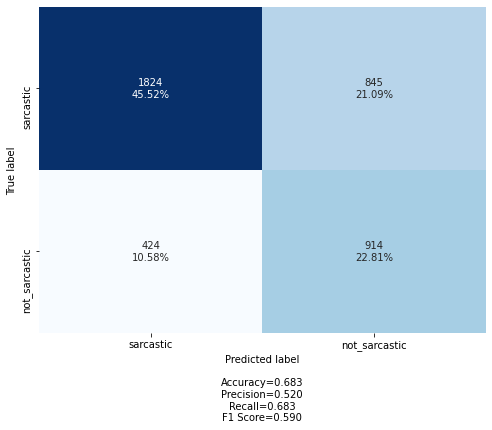

time: 375 ms (started: 2021-08-16 07:16:45 +02:00)


In [ ]:
y_pred = opt_df.predict(test_x)
cf_matrix = confusion_matrix(y_pred, test_y)
labels = ['sarcastic','not_sarcastic']
cf_matrix
make_confusion_matrix(cf_matrix,categories=labels, figsize=(8,6), cbar=False)

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 2

probs = opt_df.predict_proba(test_x)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_y, probs[:,i], pos_label=i)
    
random_probs = [0 for i in range(len(test_y))]
p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)

16/16 - 0s
time: 234 ms (started: 2021-08-16 07:16:46 +02:00)


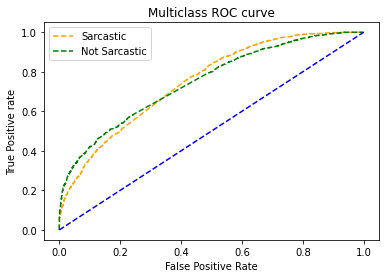

time: 109 ms (started: 2021-08-16 07:16:46 +02:00)


In [ ]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Sarcastic')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Not Sarcastic')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300)